In [2]:
import pandas as pd

# Load the uploaded dataset to examine its structure and contents
data = pd.read_csv('cybersecurity_attacks.csv')

# Display basic information about the dataset to understand its structure
data_info = {
    "Columns": data.columns.tolist(),
    "Shape": data.shape,
    "Sample Rows": data.head()
}

data_info

{'Columns': ['Timestamp',
  'Source IP Address',
  'Destination IP Address',
  'Source Port',
  'Destination Port',
  'Protocol',
  'Packet Length',
  'Packet Type',
  'Traffic Type',
  'Payload Data',
  'Malware Indicators',
  'Anomaly Scores',
  'Alerts/Warnings',
  'Attack Type',
  'Attack Signature',
  'Action Taken',
  'Severity Level',
  'User Information',
  'Device Information',
  'Network Segment',
  'Geo-location Data',
  'Proxy Information',
  'Firewall Logs',
  'IDS/IPS Alerts',
  'Log Source'],
 'Shape': (40000, 25),
 'Sample Rows':              Timestamp Source IP Address Destination IP Address  Source Port  \
 0  2023-05-30 06:33:58     103.216.15.12           84.9.164.252        31225   
 1  2020-08-26 07:08:30    78.199.217.198         66.191.137.154        17245   
 2  2022-11-13 08:23:25      63.79.210.48          198.219.82.17        16811   
 3  2023-07-02 10:38:46     163.42.196.10        101.228.192.255        20018   
 4  2023-07-16 13:11:07     71.166.185.76   

In [3]:
# Check for missing values and data types in the dataset
missing_values = data.isnull().sum()
data_types = data.dtypes

# Summarize missing values and data types
missing_summary = pd.DataFrame({
    "Missing Values": missing_values,
    "Data Type": data_types
}).sort_values(by="Missing Values", ascending=False)

# Display the summary to understand the state of the data
missing_summary


,Missing Values,Data Type
Alerts/Warnings,20067,object
IDS/IPS Alerts,20050,object
Malware Indicators,20000,object
Firewall Logs,19961,object
Proxy Information,19851,object
Attack Type,0,object
Geo-location Data,0,object
Network Segment,0,object
Device Information,0,object
User Information,0,object


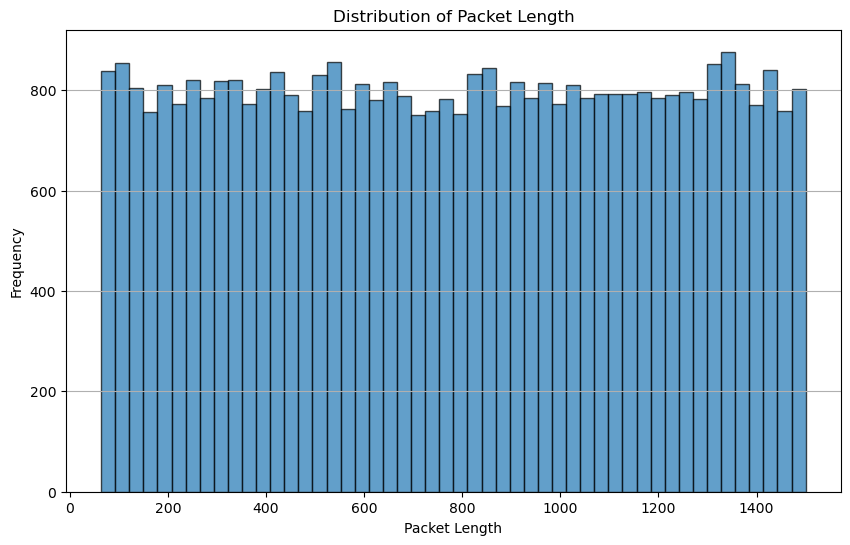

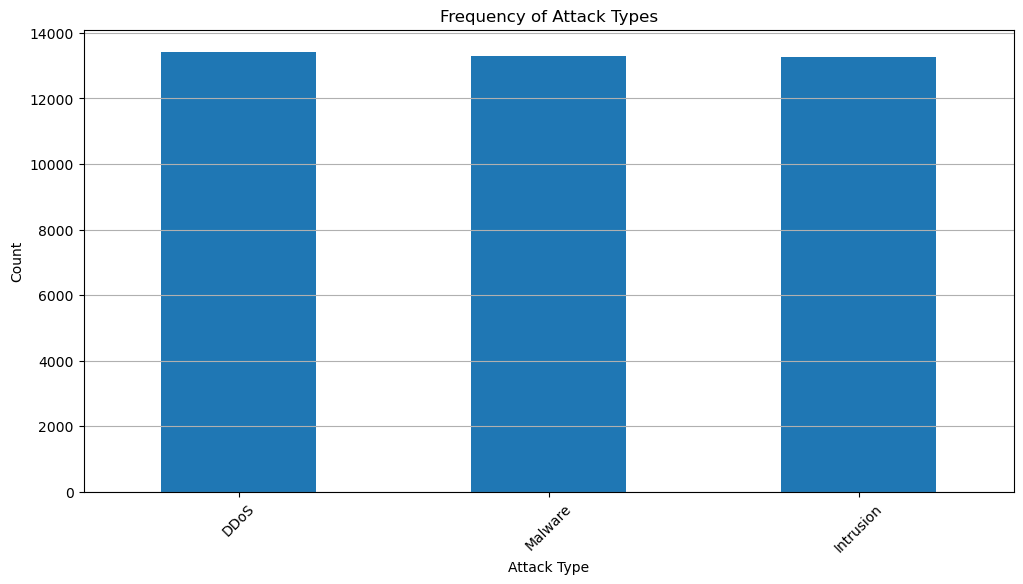

,Source Port,Destination Port,Packet Length,Anomaly Scores
count,40000.000000,40000.000000,40000.000000,40000.000000
mean,32970.356450,33150.868650,781.452725,50.113473
std,18560.425604,18574.668842,416.044192,28.853598
min,1027.000000,1024.000000,64.000000,0.000000
25%,16850.750000,17094.750000,420.000000,25.150000
50%,32856.000000,33004.500000,782.000000,50.345000
75%,48928.250000,49287.000000,1143.000000,75.030000
max,65530.000000,65535.000000,1500.000000,100.000000


In [4]:
import matplotlib.pyplot as plt

# Summary statistics for numerical columns
numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns
numerical_summary = data[numerical_columns].describe()

# Visualization: Distribution of Packet Length
plt.figure(figsize=(10, 6))
plt.hist(data['Packet Length'], bins=50, alpha=0.7, edgecolor='black')
plt.title('Distribution of Packet Length')
plt.xlabel('Packet Length')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

# Visualization: Distribution of Attack Types
plt.figure(figsize=(12, 6))
data['Attack Type'].value_counts().plot(kind='bar')
plt.title('Frequency of Attack Types')
plt.xlabel('Attack Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

numerical_summary


In [5]:
from sklearn.utils import resample

# Handle class imbalance: Examine class distribution in "Attack Type"
attack_type_counts = data['Attack Type'].value_counts()

# Separate majority and minority classes
majority_class = attack_type_counts.idxmax()
minority_classes = attack_type_counts.index[attack_type_counts < attack_type_counts.max()]

# Resampling to balance the classes
resampled_data = []
for attack_type in attack_type_counts.index:
    class_data = data[data['Attack Type'] == attack_type]
    if attack_type in minority_classes:
        resampled_class = resample(class_data, replace=True, n_samples=attack_type_counts.max(), random_state=42)
    else:
        resampled_class = class_data  # Keep majority class as-is
    resampled_data.append(resampled_class)

# Combine resampled data
balanced_data = pd.concat(resampled_data)

# Verify class balance
balanced_attack_type_counts = balanced_data['Attack Type'].value_counts()

# Handle missing data: Fill missing values for critical columns
critical_columns = ['Alerts/Warnings', 'IDS/IPS Alerts', 'Malware Indicators']
balanced_data[critical_columns] = balanced_data[critical_columns].fillna('Unknown')

# Display new class distribution and data shape after balancing and filling missing values
balanced_attack_type_counts, balanced_data.shape


(Attack Type
 DDoS         13428
 Malware      13428
 Intrusion    13428
 Name: count, dtype: int64,
 (40284, 25))

In [6]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder

# Encode categorical variables for compatibility with feature selection
categorical_columns = balanced_data.select_dtypes(include=['object']).columns
encoder = LabelEncoder()

encoded_data = balanced_data.copy()
for col in categorical_columns:
    encoded_data[col] = encoder.fit_transform(encoded_data[col])

# Separate features and target variable
X = encoded_data.drop(columns=['Attack Type'])
y = encoded_data['Attack Type']

# Calculate feature importance using mutual information
feature_importances = mutual_info_classif(X, y, random_state=42)
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Display the top 10 most important features
top_features = feature_importance_df.head(10)
top_features


,Feature,Importance
0,Timestamp,0.178487
3,Source Port,0.176066
1,Source IP Address,0.173023
9,Payload Data,0.171158
16,User Information,0.166967
2,Destination IP Address,0.165982
4,Destination Port,0.165501
17,Device Information,0.142438
11,Anomaly Scores,0.132790
19,Geo-location Data,0.127433


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Select top features for model training
selected_features = top_features['Feature'].tolist()
X_selected = X[selected_features]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42, stratify=y)

# Train and evaluate Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

# Train and evaluate k-Nearest Neighbors Classifier
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)
knn_predictions = knn_model.predict(X_test)

# Evaluate and summarize results
rf_accuracy = accuracy_score(y_test, rf_predictions)
knn_accuracy = accuracy_score(y_test, knn_predictions)

rf_classification_report = classification_report(y_test, rf_predictions)
knn_classification_report = classification_report(y_test, knn_predictions)

# Create a summary of the results
results_summary = {
    "Random Forest": {
        "Accuracy": rf_accuracy,
        "Classification Report": rf_classification_report
    },
    "k-Nearest Neighbors": {
        "Accuracy": knn_accuracy,
        "Classification Report": knn_classification_report
    }
}

results_summary


{'Random Forest': {'Accuracy': 0.603590931656462,
  'Classification Report': '              precision    recall  f1-score   support\n\n           0       0.50      0.61      0.55      4028\n           1       0.68      0.60      0.64      4029\n           2       0.67      0.60      0.63      4029\n\n    accuracy                           0.60     12086\n   macro avg       0.62      0.60      0.61     12086\nweighted avg       0.62      0.60      0.61     12086\n'},
 'k-Nearest Neighbors': {'Accuracy': 0.42321694522588116,
  'Classification Report': '              precision    recall  f1-score   support\n\n           0       0.38      0.43      0.40      4028\n           1       0.45      0.48      0.46      4029\n           2       0.45      0.37      0.41      4029\n\n    accuracy                           0.42     12086\n   macro avg       0.43      0.42      0.42     12086\nweighted avg       0.43      0.42      0.42     12086\n'}}

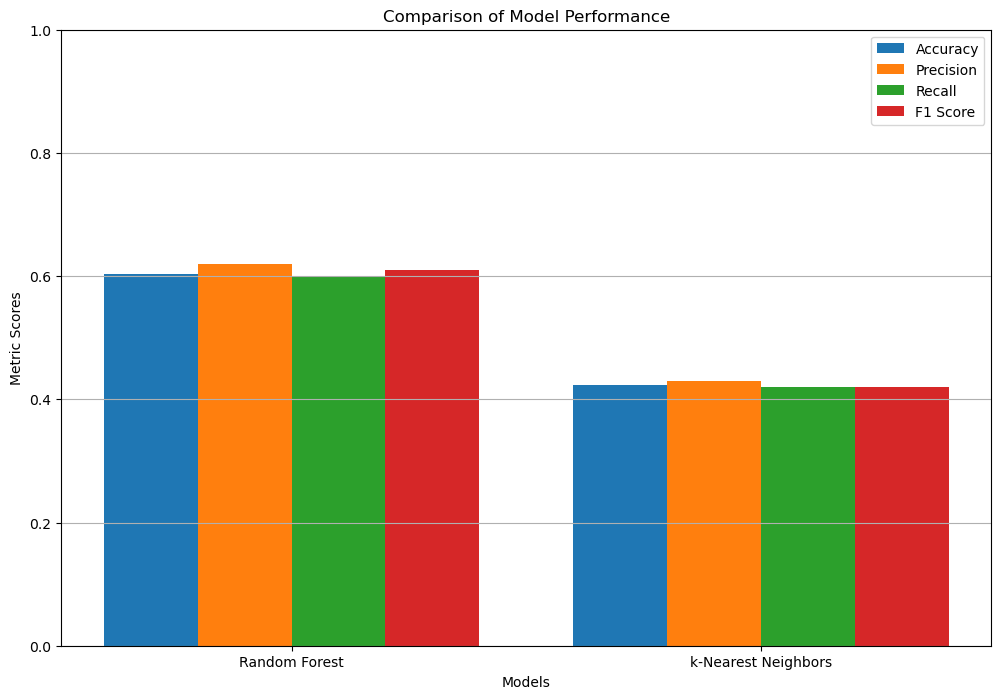

In [8]:
# Re-import necessary libraries and recreate the dataset for graphing purposes
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Recreate model metrics
model_metrics = {
    "Model": ["Random Forest", "k-Nearest Neighbors"],
    "Accuracy": [0.6036, 0.4232],
    "Precision": [0.62, 0.43],  # Weighted avg from classification reports
    "Recall": [0.60, 0.42],
    "F1 Score": [0.61, 0.42]
}

metrics_df = pd.DataFrame(model_metrics)

# Plot the metrics
plt.figure(figsize=(12, 8))
x = np.arange(len(metrics_df["Model"]))
width = 0.2

plt.bar(x - width, metrics_df["Accuracy"], width, label="Accuracy")
plt.bar(x, metrics_df["Precision"], width, label="Precision")
plt.bar(x + width, metrics_df["Recall"], width, label="Recall")
plt.bar(x + 2 * width, metrics_df["F1 Score"], width, label="F1 Score")

# Add labels, title, and legend
plt.xlabel("Models")
plt.ylabel("Metric Scores")
plt.title("Comparison of Model Performance")
plt.xticks(x + width / 2, metrics_df["Model"])
plt.ylim(0, 1)
plt.legend(loc="best")
plt.grid(axis="y")

# Display the graph
plt.show()
